In [105]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import preprocessing
from sklearn import metrics
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import pickle

In [125]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "mathtext.default": "regular",
    "xtick.direction" : "in",
    "ytick.direction" : "in",
    "xtick.top" : True,
    "ytick.right" : True,
    "axes.unicode_minus" : True
})

## Load data and prepare the dataframe

In [2]:
df0 = pd.read_csv("../data/clean_data.csv", parse_dates=[1])
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13764723 entries, 0 to 13764722
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   Unnamed: 0           int64         
 1   FL_DATE              datetime64[ns]
 2   OP_UNIQUE_CARRIER    object        
 3   ORIGIN_AIRPORT_ID    int64         
 4   DEST_AIRPORT_ID      int64         
 5   DEP_DELAY            float64       
 6   AIR_TIME             float64       
 7   CARRIER_DELAY        float64       
 8   WEATHER_DELAY        float64       
 9   NAS_DELAY            float64       
 10  SECURITY_DELAY       float64       
 11  LATE_AIRCRAFT_DELAY  float64       
 12  FRAC_YEAR            float64       
 13  FRAC_DAY             float64       
dtypes: datetime64[ns](1), float64(9), int64(3), object(1)
memory usage: 1.4+ GB


In [3]:
# Create the delay column
delay_thresh=15.
df0=df0.assign(DELAY_TF=pd.Series(df0['DEP_DELAY']>delay_thresh).values.astype(float)) # declare delay TRUE/FALSE 

# One-hot encode categorical variables
df0 = pd.get_dummies(df0,columns=['OP_UNIQUE_CARRIER','ORIGIN_AIRPORT_ID','DEST_AIRPORT_ID'], drop_first=True, dtype=float) # one-hot

# Convert cyclical vars (frac_day & frac_year) to sin and cos columns
df0 = df0.assign(YEAR_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
df0 = df0.assign(YEAR_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_YEAR']/1.0)).values)
df0 = df0.assign(DAY_FRAC_sin=pd.Series(np.sin(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
df0 = df0.assign(DAY_FRAC_cos=pd.Series(np.cos(2.*np.pi*df0['FRAC_DAY']/1.0)).values)
df0 = df0.drop(columns=['FRAC_DAY','FRAC_YEAR'])

# Additional cleaning
df0 = df0.drop(columns=['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY','DEP_DELAY'])
df0 = df0.loc[:, ~df0.columns.str.contains('^Unnamed')]

## Data splits
Separate into testing (2023), validation (2022), and training (all other years).

In [36]:
df_test = df0[df0["FL_DATE"].dt.year.isin([2023])]
df_val =  df0[df0["FL_DATE"].dt.year.isin([2022])]
df_train = df0[~df0["FL_DATE"].dt.year.isin([2022,2023])]

y_test = df_test['DELAY_TF']
X_test = df_test.drop(columns=['DELAY_TF','FL_DATE'])

y_val = df_val['DELAY_TF']
X_val = df_val.drop(columns=['DELAY_TF','FL_DATE'])

y_train = df_train['DELAY_TF']
X_train = df_train.drop(columns=['DELAY_TF']) # Keep date temporarily for further splits

In [65]:
# Clear up some memory
del df0,df_test,df_val,df_train

In [71]:
X_val.head()

,AIR_TIME,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,ORIGIN_AIRPORT_ID_10721,ORIGIN_AIRPORT_ID_11057,...,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,DEST_AIRPORT_ID_14869,YEAR_FRAC_sin,YEAR_FRAC_cos,DAY_FRAC_sin,DAY_FRAC_cos
11630232,0.321617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000024,1.000000,0.008727,0.999962
11630559,0.442882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000084,1.000000,0.030539,0.999534
11631934,0.347979,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000048,1.000000,0.017452,0.999848
11632203,0.052724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004901,0.999988,0.976296,-0.216440
11632204,0.049209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006216,0.999981,0.766044,-0.642788


In [38]:
# Scale the airtime column
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[['AIR_TIME']])

X_train[['AIR_TIME']] = scaler.transform(X_train[['AIR_TIME']])
X_val[['AIR_TIME']] = scaler.transform(X_val[['AIR_TIME']])
X_test[['AIR_TIME']] = scaler.transform(X_test[['AIR_TIME']])

In [72]:
X_val.head()

,AIR_TIME,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,ORIGIN_AIRPORT_ID_10721,ORIGIN_AIRPORT_ID_11057,...,DEST_AIRPORT_ID_13487,DEST_AIRPORT_ID_13930,DEST_AIRPORT_ID_14107,DEST_AIRPORT_ID_14747,DEST_AIRPORT_ID_14771,DEST_AIRPORT_ID_14869,YEAR_FRAC_sin,YEAR_FRAC_cos,DAY_FRAC_sin,DAY_FRAC_cos
11630232,0.321617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000024,1.000000,0.008727,0.999962
11630559,0.442882,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000084,1.000000,0.030539,0.999534
11631934,0.347979,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000048,1.000000,0.017452,0.999848
11632203,0.052724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.004901,0.999988,0.976296,-0.216440
11632204,0.049209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.006216,0.999981,0.766044,-0.642788


In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 886100 entries, 12877149 to 13764722
Data columns (total 50 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   AIR_TIME                 886100 non-null  float64
 1   OP_UNIQUE_CARRIER_AS     886100 non-null  float64
 2   OP_UNIQUE_CARRIER_B6     886100 non-null  float64
 3   OP_UNIQUE_CARRIER_DL     886100 non-null  float64
 4   OP_UNIQUE_CARRIER_NK     886100 non-null  float64
 5   OP_UNIQUE_CARRIER_OO     886100 non-null  float64
 6   OP_UNIQUE_CARRIER_UA     886100 non-null  float64
 7   OP_UNIQUE_CARRIER_WN     886100 non-null  float64
 8   ORIGIN_AIRPORT_ID_10721  886100 non-null  float64
 9   ORIGIN_AIRPORT_ID_11057  886100 non-null  float64
 10  ORIGIN_AIRPORT_ID_11278  886100 non-null  float64
 11  ORIGIN_AIRPORT_ID_11292  886100 non-null  float64
 12  ORIGIN_AIRPORT_ID_11298  886100 non-null  float64
 13  ORIGIN_AIRPORT_ID_11433  886100 non-null  float64
 14  

In [70]:
# Once we see new data, we'll need to scale the airtime
print(scaler.data_min_)
print(scaler.data_max_)

[19.]
[588.]


## Logistic regression

We will separate the training data into different time periods (different years), and use logistic regression (fastest model to train on), to check which of these time periods is ideal

In [55]:
time_periods = [(2018,2021),(2018,2019),(2015,2021),(2015,2019),(2012,2021),(2012,2019)]
year_column = X_train['FL_DATE'].dt.year

This next cell takes time...

In [58]:
train_now = False # Make this true when ready

if train_now:    
    log_reg_models = []
    log_reg_pred = [] # predictions on the validation set

    for tp in time_periods:
        print(f"Training on {tp[0]} to {tp[1]}")

        i_tt = np.logical_and(year_column>=tp[0], year_column<=tp[1]).values
        X_tt = X_train.iloc[i_tt].drop(columns=['FL_DATE'])
        y_tt = y_train.iloc[i_tt]

        mod = LogisticRegression(class_weight = 'balanced')
        mod.fit(X_tt, y_tt)

        log_reg_models.append(mod)
        log_reg_pred.append(mod.predict_proba(X_val))

    del X_tt,y_tt
    
    # Save models to pickle
    for i,model in enumerate(log_reg_models):
        filename = f"../models/log_reg_{time_periods[i][0]}_{time_periods[i][1]}.pickle"
        print(filename)
        with open(filename, 'wb') as f:
            pickle.dump(model, f)

Training on 2018 to 2021
Training on 2018 to 2019
Training on 2015 to 2021
Training on 2015 to 2019
Training on 2012 to 2021
Training on 2012 to 2019


In [77]:
# import sys

# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
#                           locals().items())), key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

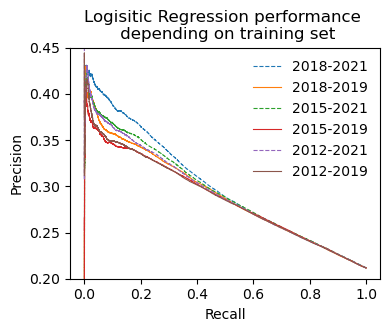

In [90]:
plt.figure(figsize=(4,3))
plt.xlabel('Recall')
plt.ylabel('Precision')

for tp, pred in zip(time_periods, log_reg_pred):
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, pred[:,1])
    
    # models including pandemic with dashed line
    ls = '--' if tp[1]==2021 else '-'
    
    plt.plot(recall[::10], precision[::10], label=f"{tp[0]}-{tp[1]}", ls=ls, lw=0.8)
    
plt.ylim([0.2,0.45])
plt.title("Logisitic Regression performance \n depending on training set")
plt.legend(frameon=False)
plt.show()

This shows that it is better, at least for logistic regression, to include pandemic data, and not too many previous years. 2018-2021 is the best performing model. Now we'll train random forest and xg boost model on those years. We'll also train for 2012-2019, which we assumed would be the best training set, but is one of the worst models for logistic regression.

## Random forest and XGBoost

In [95]:
train_now = False # Make this true when ready

if train_now:
    i_tt1 = np.logical_and(year_column>=2012, year_column<=2019).values
    i_tt2 = np.logical_and(year_column>=2018, year_column<=2021).values

    X_tt1 = X_train.iloc[i_tt1].drop(columns=['FL_DATE'])
    y_tt1 = y_train.iloc[i_tt1]

    X_tt2 = X_train.iloc[i_tt2].drop(columns=['FL_DATE'])
    y_tt2 = y_train.iloc[i_tt2]

    print("Training RF on 2012-2019")
    RF1 = RandomForestClassifier(n_estimators=10)
    RF1.fit(X_tt1, y_tt1)
    with open("../models/RF_2012_2019.pickle", 'wb') as f:
        pickle.dump(RF1, f)

    print("Training RF on 2018-2021")
    RF2 = RandomForestClassifier(n_estimators=10)
    RF2.fit(X_tt2, y_tt2)
    with open("../models/RF_2018_2021.pickle", 'wb') as f:
        pickle.dump(RF2, f)

    print("Training XG on 2012-2019")
    XG1 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=10)
    XG1.fit(X_tt1, y_tt1)
    with open("../models/XG_2012_2019.pickle", 'wb') as f:
        pickle.dump(XG1, f)

    print("Training XG on 2018-2021")
    XG2 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=10)
    XG2.fit(X_tt2, y_tt2)
    with open("../models/XG_2018_2021.pickle", 'wb') as f:
        pickle.dump(XG2, f)

    del X_tt1,y_tt1,X_tt2,y_tt2

Training RF on 2012-2019
Training RF on 2018-2021
Training XG on 2012-2019
Training XG on 2018-2021


## Performance metrics

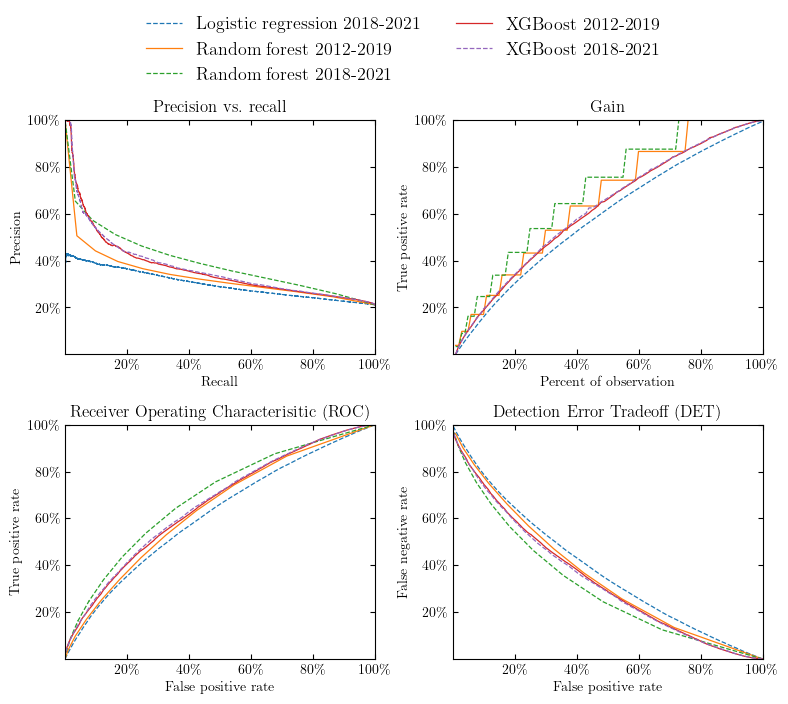

In [166]:
fig,axes = plt.subplots(2,2,figsize=(9,7))
fig.subplots_adjust(hspace=0.3,wspace=0.25)
axes[0][0].set_title('Precision vs. recall')
axes[0][0].set_xlabel('Recall')
axes[0][0].set_ylabel('Precision')
axes[0][1].set_title('Gain')
axes[0][1].set_xlabel('Percent of observation')
axes[0][1].set_ylabel('True positive rate')
axes[1][0].set_title('Receiver Operating Characterisitic (ROC)')
axes[1][0].set_xlabel('False positive rate')
axes[1][0].set_ylabel('True positive rate')
axes[1][1].set_title('Detection Error Tradeoff (DET)')
axes[1][1].set_xlabel('False positive rate')
axes[1][1].set_ylabel('False negative rate')

labels = ("Logistic regression 2018-2021", 
          "Random forest 2012-2019", "Random forest 2018-2021",
          "XGBoost 2012-2019", "XGBoost 2018-2021")

for i,model in enumerate((log_reg_models[0],RF1,RF2,XG1,XG2)):
# for i,model in enumerate((log_reg_models[0],)):

    
    # models including pandemic with dashed line
    ls = '--' if i%2==0 else '-'
    
    y_pred = model.predict_proba(X_val)[:,1]
    
    # Precision Recall
    precision, recall, thresholds = metrics.precision_recall_curve(y_val, y_pred)
    axes[0][0].plot(recall, precision, ls=ls, lw=0.9, label=labels[i])
    
    # ROC,DET
    fpr,tpr,_ = metrics.roc_curve(y_val, y_pred)
    axes[1][0].plot(fpr, tpr, ls=ls, lw=0.9)

#     fnr = 1-recall # wrong size?
    fpr,fnr,_ = metrics.det_curve(y_val, y_pred)
    axes[1][1].plot(fpr, fnr, ls=ls, lw=0.9)
    
    # Gains plot (following code from Erdos Bootcamp)
    pred_df = pd.DataFrame({'actual':y_val,'prob':y_pred})
    ps = [pred_df.prob.quantile(i) for i in np.arange(1, 0, -0.01)] # getting the p cutoffs for quantiles
    tprs = []
    for i,p in enumerate(ps):
        pred = 1*(pred_df.prob.values >= p)
        ## using the fact the tpr is recall
        tprs.append(metrics.recall_score(pred_df.actual.values, pred))
    axes[0][1].plot(np.arange(0.01,1.01,0.01), tprs, ls=ls, lw=0.9)
    


axes[0][1].plot([0,1],[1,1],'k:', lw=0.5)

# axes[0][0].plot([0,1],[1,1],'k:', lw=0.5, label='foo')
axes[0][0].legend(frameon=False, ncol=2, bbox_to_anchor = (0.5,0.98), 
                  loc="center", bbox_transform=fig.transFigure, fontsize=13)

for ax in axes.ravel():
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0],[r"20\%",r"40\%",r"60\%",r"80\%",r"100\%"])
    
# plt.tight_layout()
fig.savefig("metrics_plot.pdf", bbox_inches='tight')
plt.show()

In [169]:
for i,model in enumerate((log_reg_models[0],RF1,RF2,XG1,XG2)):
    y_pred = model.predict_proba(X_val)[:,1]
    
    print(labels[i])
    cm = metrics.confusion_matrix(y_val, y_pred >= 0.5)
    print(cm/float(len(y_val)))
    print(classification_report(y_val, y_pred >= 0.5))

Logistic regression 2018-2021
[[0.45416867 0.33410301]
 [0.08680635 0.12492198]]
              precision    recall  f1-score   support

         0.0       0.84      0.58      0.68    982516
         1.0       0.27      0.59      0.37    263902

    accuracy                           0.58   1246418
   macro avg       0.56      0.58      0.53   1246418
weighted avg       0.72      0.58      0.62   1246418

Random forest 2012-2019
[[0.59504837 0.1932233 ]
 [0.12023174 0.09149659]]
              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79    982516
         1.0       0.32      0.43      0.37    263902

    accuracy                           0.69   1246418
   macro avg       0.58      0.59      0.58   1246418
weighted avg       0.72      0.69      0.70   1246418

Random forest 2018-2021
[[0.64303227 0.1452394 ]
 [0.1196252  0.09210313]]
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83    982516
      

## Feature importance

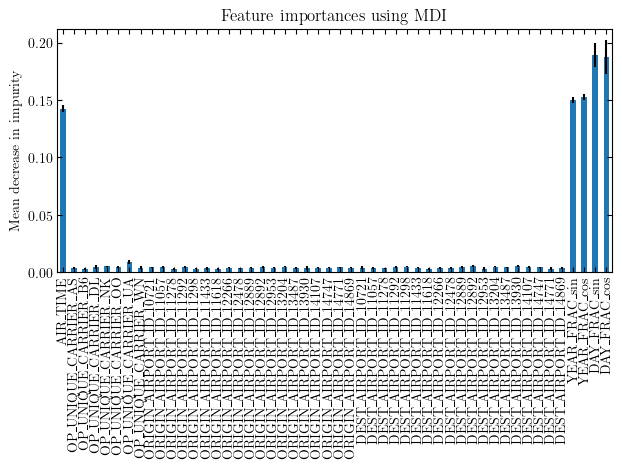

In [177]:
# feature importance based on impurity
importances = RF2.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF2.estimators_], axis=0)
# feature_names = [f"feature {i}" for i in range(X_train.shape[1]-1)]
feature_names = X_val.columns
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

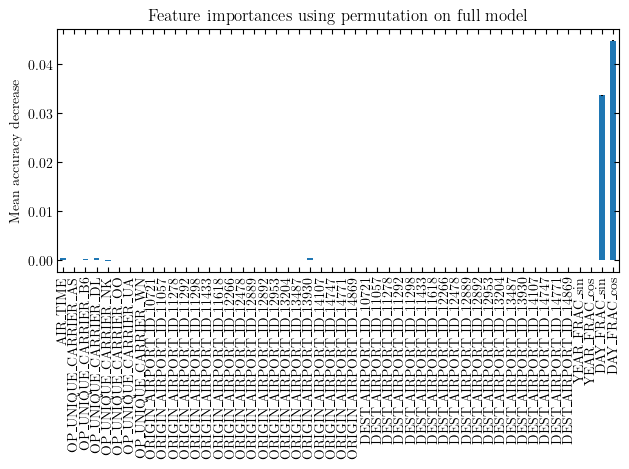

In [178]:
# based on permutation
model_fi = permutation_importance(model, X_val, y_val, n_repeats=5, random_state=42)
forest_importances = pd.Series(model_fi.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=model_fi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Calibration